Use U-Net for region proposals. Use conv classifier on top of that. 

~~1. region proposals~~
2. slide window approach on proposed regions, using different window sizes, differenced by 10 pixels
3. test on different images from video
4. video pipeline, smoothing over 10 frames

In [1]:
from unet import *

Using TensorFlow backend.


In [118]:
import cv2
import numpy as np
import time; import os; import pickle; import glob
import matplotlib.image as mpimg; import matplotlib.pyplot as plt
import glob 
from scipy.ndimage.measurements import label
import datetime as dt
import csv
%matplotlib inline

In [3]:
model = get_unet()
model.load_weights('./output/model_11epochs.hdf5') # dice_coeff = 0.4398

In [4]:
h, w, c = 1200, 1920, 3

In [5]:
def resize_image_for_unet(img):
    return cv2.resize(img, (w,h))

In [6]:
def select_random_frames(path='./project_video_frames/*.jpeg', n=10):
    frames = glob.glob(path)
    indices = np.random.choice(np.arange(len(frames)), n, replace=False)
    img_arr = np.zeros((n,h,w,3))
    for i,v in enumerate(indices):
        img_arr[i,] = resize_image_for_unet(mpimg.imread(frames[i]))
    return img_arr

In [11]:
img_arr = select_random_frames('./test_images/*.jpg',n=7)

In [12]:
pred_arr = model.predict(img_arr)

In [13]:
def plot_img_mask(img_arr, pred_arr):
    n = img_arr.shape[0]
    
    fig = plt.figure()
    fig.set_figwidth(8); fig.set_figheight(n*3)
    
    for i in np.arange(n): 
        img = np.array(img_arr[i,], dtype=np.uint8)
        
        ax = fig.add_subplot(n, 2, i*2+1)
        ax = plt.imshow(img)
        
        pred = np.array(pred_arr[i,]*255, dtype=np.uint8)
        pred = cv2.cvtColor(pred,cv2.COLOR_GRAY2RGB)
        pred[:,:,[1,2]] = 0*pred[:,:,1:2]
        pred = cv2.addWeighted(pred, 0.5, img, 1, 0)
        
        ax = fig.add_subplot(n, 2, i*2+2)
        ax = plt.imshow(pred)
        
    return ax

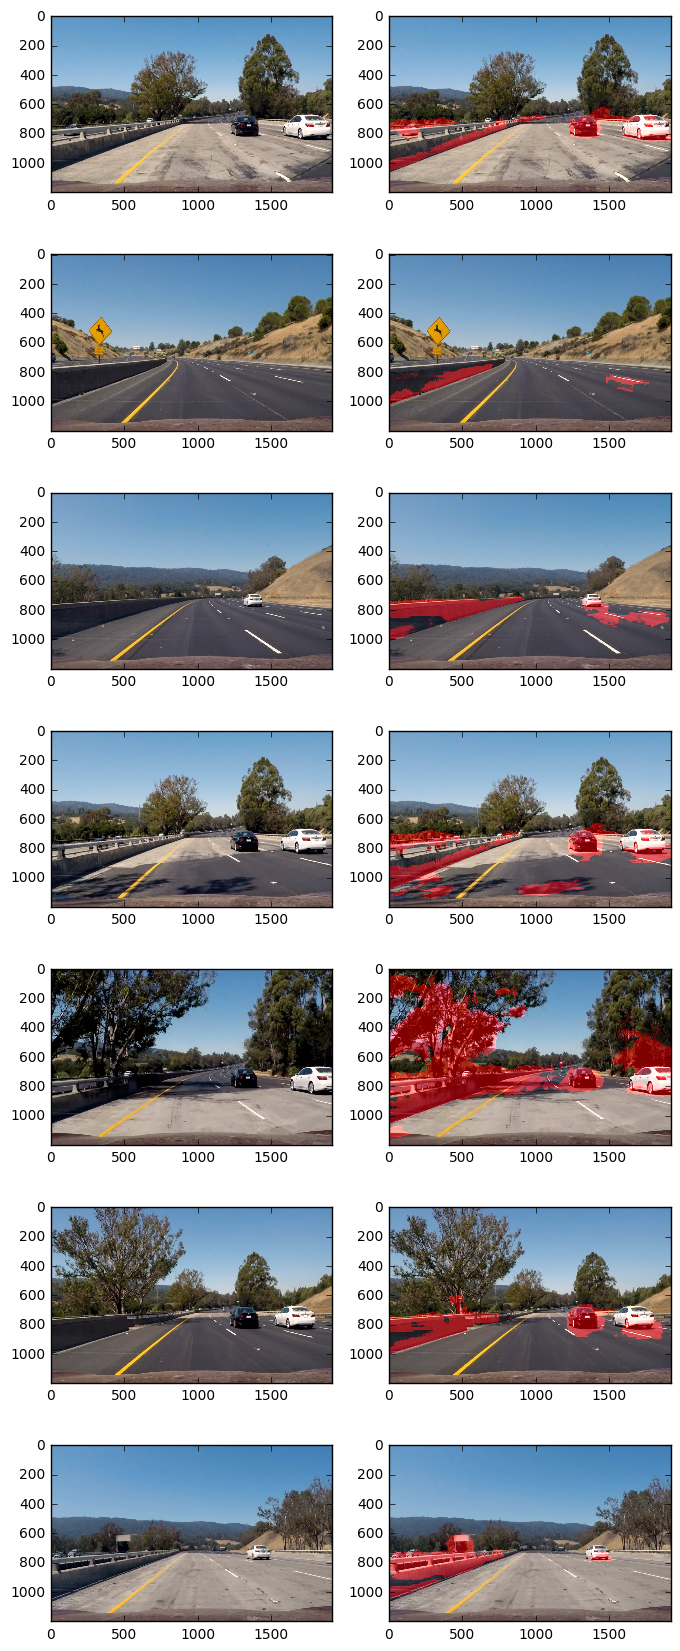

In [14]:
plot_img_mask(img_arr, pred_arr)

In [95]:
img_arr = select_random_frames('./test_images/*.jpg',n=1)
start = time.time()
pred_arr = model.predict(img_arr)
end = time.time()
print("Prediction time for one image: {}".format(end-start))

Prediction time for one image: 1.5196850299835205


### Pipeline to process video by frame and output images and a log

In [62]:
img_arr = np.zeros((7,720,1280,3))
for i,v in enumerate(glob.glob('./test_images/*.jpg')):
        img_arr[i,] = mpimg.imread(v)

In [102]:
def draw_labeled_bboxes(img, labels, n_cars):
    img_ = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, n_cars+1):
        # Find pixels with each car_number label value
        nonzero = (labels == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bboxes = []
        if ((np.max(nonzeroy)-np.min(nonzeroy)>35) & (np.max(nonzerox)-np.min(nonzerox)>35)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            bboxes.append(bbox)
            # Draw the box on the image       
            cv2.rectangle(img_, bbox[0], bbox[1], (255,255,255), 6)
    # Return the image
    return img_, bboxes

In [73]:
def process_img(raw):
    raw_ = np.copy(raw).astype(np.uint8)
    raw_[:360,:,:] = 0
    img =  cv2.resize(raw_, (1920,1200))
    
    pred_arr = model.predict(np.expand_dims(img, 0))
    pred = pred_arr[0,:,:,-1].astype(np.uint8)
    small = cv2.resize(pred, (1280,720))
    labels, n_cars = label(small)
    small_, bboxes = draw_labeled_bboxes(small, labels, n_cars)
    
    small_color = cv2.cvtColor(small_, cv2.COLOR_GRAY2RGB)
    
    small_color[:,:,[1,2]] = 0*small_color[:,:,1:2]
    weighted = cv2.addWeighted(small_color.astype(np.uint8), 1, raw.astype(np.uint8), 1, 0)
    
    return weighted

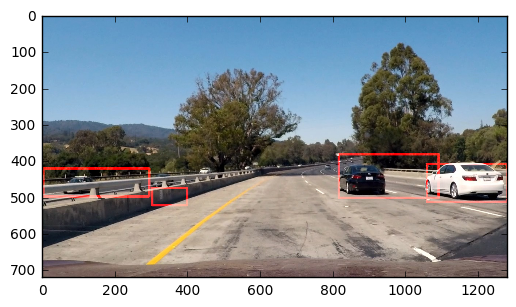

In [74]:
output = process_img(img_arr[0])
plt.imshow(output)

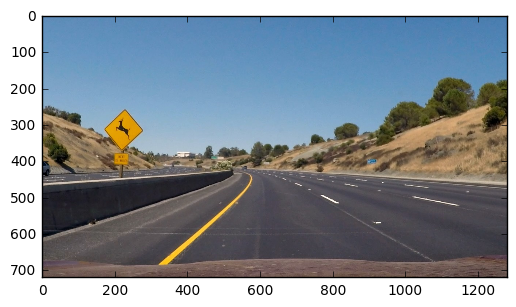

In [75]:
output = process_img(img_arr[1])
plt.imshow(output)

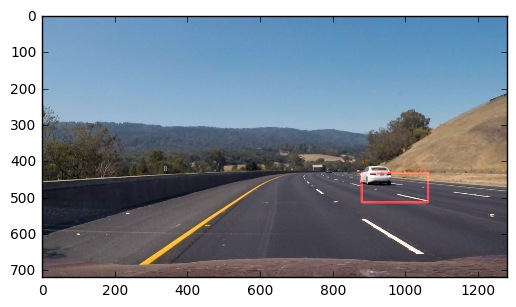

In [67]:
output = process_img(img_arr[2])
plt.imshow(output)

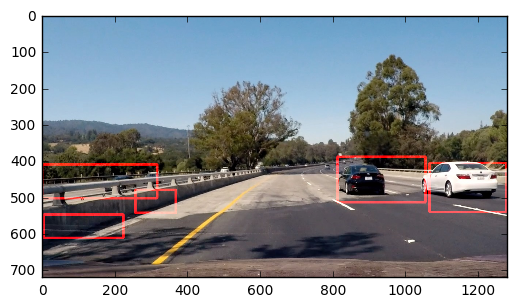

In [68]:
output = process_img(img_arr[3])
plt.imshow(output)

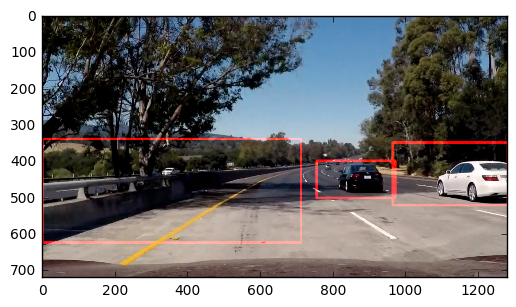

In [69]:
output = process_img(img_arr[4])
plt.imshow(output)

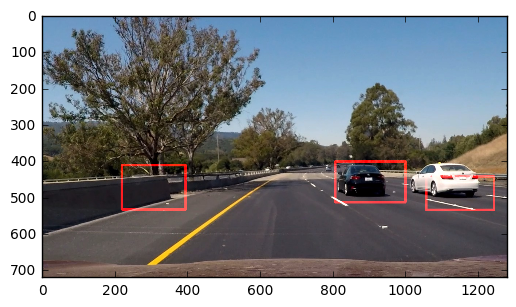

In [70]:
output = process_img(img_arr[5])
plt.imshow(output)

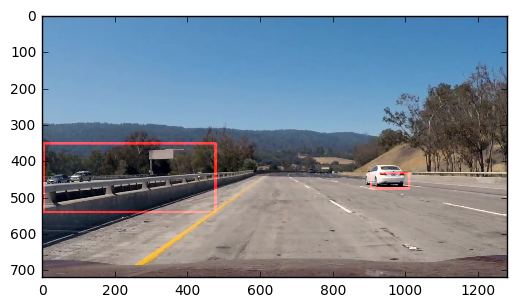

In [76]:
output = process_img(img_arr[6])
plt.imshow(output)

In [77]:
b = len(glob.glob('./test_images/*.jpeg'))
img_arr = np.zeros((b,720,1280,3))
for i,v in enumerate(glob.glob('./test_images/*.jpeg')):
        img_arr[i,] = mpimg.imread(v)

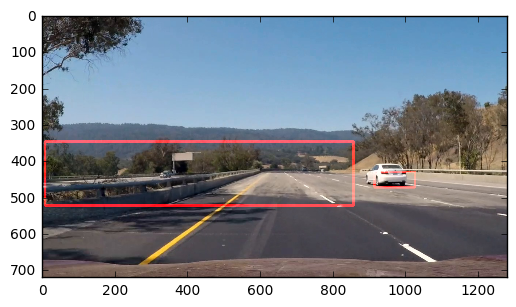

In [103]:
output = process_img(img_arr[36])
plt.imshow(output)

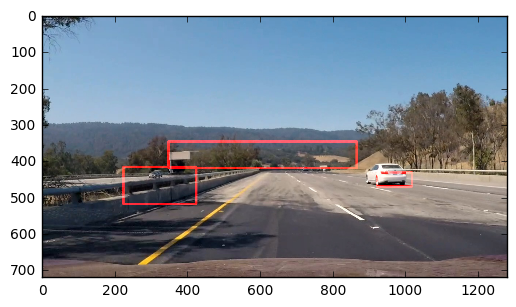

In [107]:
output = process_img(img_arr[40])
plt.imshow(output)

### Pipeline for Diagnosis

In [591]:
def draw_labeled_bboxes(raw, labels, n_cars):
    bboxes = []
    img = np.copy(raw)
    
    # Iterate through all detected cars
    for car_number in range(1, n_cars+1):
        # Find pixels with each car_number label value
        nonzero = (labels == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            
            # Draw the box on the image 
            bboxes.append(bbox)
            cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 6)
    
            
    # Return the image
    return img, bboxes

def update_bboxes(img, bboxes):
    
            
    # sliding window and use classifier again
    heatmap = np.zeros((img.shape[1], img.shape[0]))
    
    # TODO
    
    # threshold heatmap to create regions
    heatmap_thresholded = heatmap
    heatmap_thresholded[heatmap < 3] = 0
    labels, n_cars = label(heatmap_thresholded)
    img, bboxes = draw_labeled_bboxes(img, labels, n_cars)
    return img, bboxes

global a
a = 0
def process_save_img(raw):
    
    global a 
    raw_ = np.copy(raw).astype(np.uint8)
    raw_[:360,:,:] = 0
    img =  cv2.resize(raw_, (1920,1200))
    
    pred_arr = model.predict(np.expand_dims(img, 0))
    pred = pred_arr[0,:,:,-1].astype(np.uint8)
    small = cv2.resize(pred, (1280,720))
    labels, n_cars = label(small)
    small_, bboxes = draw_labeled_bboxes(small, labels, n_cars)
    small_color = cv2.cvtColor(small_, cv2.COLOR_GRAY2RGB)
    
    small_color[:,:,[1,2]] = 0*small_color[:,:,1:2]
    weighted = cv2.addWeighted(small_color.astype(np.uint8), 1, raw.astype(np.uint8), 1, 0)
    
    name = str(a)+'.jpg'
    
    folder = 'test_video_frames'
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    mpimg.imsave(os.path.join(folder, name), weighted)
    a += 1
    
    writer = csv.writer(open('log_test.csv', 'a'))
    
    if len(bboxes)>0: 
        for b in np.arange(len(bboxes)): 
            row = [a, bboxes[b][0][0], bboxes[b][0][1], bboxes[b][1][0], bboxes[b][1][1]]
            writer.writerow(row)
            
            
    # slide in regions
    
    # second label 
    
    return weighted

In [10]:
from moviepy.editor import VideoFileClip
import PIL


project_video_output_fname = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_video_output = clip1.fl_image(process_save_img)
project_video_output.write_videofile(project_video_output_fname, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:23<00:02,  2.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



### Classifier step on frames

1. load classifier
2. test classifier

In [154]:
from classifier import *
import pandas as pd; import itertools

In [113]:
classifier = get_conv(heatmapping=False)

In [116]:
classifier.load_weights('./output/model_heat.hdf5')

In [122]:
log = pd.read_csv('log_test.csv', header=None)

In [123]:
log.head()

0     1    2     3    4
0  1     9  359   448  530
1  1   799  402  1014  520
2  1  1052  445  1219  533
3  2     9  359   448  530
4  2   799  402  1014  520

In [1147]:
pick = 35

In [1148]:
log[log[0]==pick]

0     1    2     3    4
134  35   813  379  1083  505
135  35  1042  405  1274  546
136  35     0  416   313  508
137  35     8  547   210  630

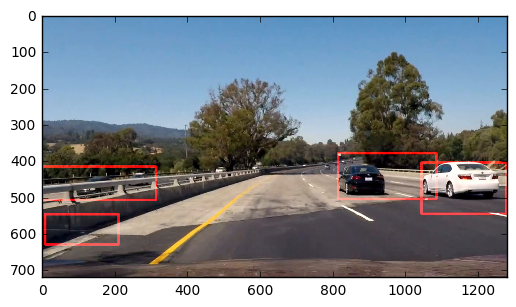

In [1149]:
img = mpimg.imread('./test_video_frames/'+str(pick-1)+'.jpg')
plt.imshow(img)

In [1150]:
def generate_search_windows(bboxes):
    h = 720
    w = 1280
    search_windows = []
    
    # I think my α, β should be informed by the previous frames
    
    for b in bboxes: 
        b = np.array(b).flatten()
        sides = sorted([b[2]-b[0], b[3]-b[1]])
        α, β = sides[0], int(sides[1]*0.8)
        
        # create 18 search windows: center x 2, corners x 4 x 4
        x1_coords = np.array([(b[2]+b[0])/2 - α/2, 
                     (b[2]+b[0])/2 - β/2,            
                     b[0] - α/2, b[0] - β/2, b[2] - α/2, b[2] - β/2,
                     b[0] - α/2, b[0] - β/2, b[2] - α/2, b[2] - β/2,
                     b[0], b[0], 
                     b[2]-α, b[2]-β, 
                     b[2]-α, b[2]-β, 
                     b[0], b[0]], dtype=np.uint16)
        y1_coords = np.array([b[1], 
                     (b[1]+b[3])/2-β/2,
                     b[1] - α/2, b[1] - β/2, b[1] - α/2, b[1] - β/2,
                     b[3] - α/2, b[3] - β/2, b[3] - α/2, b[3] - β/2,
                     b[1], b[1], 
                     b[1], b[1],
                     b[3]-α, b[3]-β,
                     b[3]-α, b[3]-β], dtype=np.uint16)
        x2_coords = x1_coords+np.tile([α, β],9)#,[β,β])
        y2_coords = y1_coords+np.tile([α, β],9)#,[β,β])
        
        valids = []
        for i in np.arange(x1_coords.shape[0]):
            if all([x1_coords[i] >= 0, y1_coords[i] >=h/2-50, x2_coords[i] <= w, y2_coords[i] <= h]):
                valids.append(i)
        sw = [((x1_coords[i],y1_coords[i]),(x2_coords[i], y2_coords[i])) for i in valids]
        search_windows.append(sw)
    
    return search_windows

In [1151]:
def search_across(bboxes):
    h = 720
    w = 1280
    search_windows = []
    
    # I think my α, β should be informed by the previous frames
    
    for b in bboxes: 
        b = np.array(b).flatten()
        sides = sorted([b[2]-b[0], b[3]-b[1]])
        α, β = sides[0], sides[1]
        
        size = 10
        
        centers = np.linspace(b[0],b[2],size).astype(np.uint16)
        
        x1 = np.array([c - α/2 for c in centers],dtype=np.uint16)
        y1 = np.array([b[1] for c in centers], dtype=np.uint16)
        x2 = x1+np.tile([α],size)
        y2 = y1+np.tile([α],size)
        
        valids = []
        for i in np.arange(x1.shape[0]):
            if all([x1[i] >= 0, y1[i] >=h/2, x2[i] <= w, y2[i] <= h]):
                valids.append(i)
        sw = [((x1[i],y1[i]), (x2[i],y2[i])) for i in valids]
        search_windows.append(sw)
    
    return search_windows

In [1220]:
def search_strategy(bboxes):
    h = 720
    w = 1280
    search_windows = []
    
    # I think my α, β should be informed by the previous frames
    
    for b in bboxes: 
        b = np.array(b).flatten()
        sides = sorted([b[2]-b[0], b[3]-b[1]])
        α, β = sides[0], sides[1]
        size = 10
        offset1 = 0
        offset2=0
        
        if α<100:
            α *= 1.5
            offset1 = int(-α/4)
            offset2 = int(-α/3)
        
        α = int(α)   
        centers = np.linspace(b[0],b[2],size).astype(np.uint16)

        x1 = np.array([c - α/2 for c in centers],dtype=np.uint16)
        x1 = np.hstack((x1,x1))
        y1_a = np.array([b[1]+offset1 for c in centers], dtype=np.uint16)
        y1_b = np.array([b[1]+offset2 for c in centers], dtype=np.uint16)
        y1 = np.hstack((y1_a, y1_b))
        x2 = x1+np.tile([α],size*2)
        y2 = y1+np.tile([α],size*2)

        valids = []
        for i in np.arange(x1.shape[0]):
            if all([x1[i] >= 0, y1[i] >=h/2, x2[i] <= w, y2[i] <= h]):
                valids.append(i)
        sw = [((x1[i],y1[i]), (x2[i],y2[i])) for i in valids]
        search_windows.append(sw)
    
    return search_windows

In [1221]:
bboxes = list(log[log[0]==pick].apply(lambda x:( (x[1],x[2]),(x[3],x[4])), axis = 1))
print(bboxes)

[((813, 379), (1083, 505)), ((1042, 405), (1274, 546)), ((0, 416), (313, 508)), ((8, 547), (210, 630))]


In [1222]:
img_ = np.copy(img)
windows = search_strategy(bboxes)
for w in windows:
    for xy in w: 
        cv2.rectangle(img_, xy[0],xy[1], (0,255,0), 5)

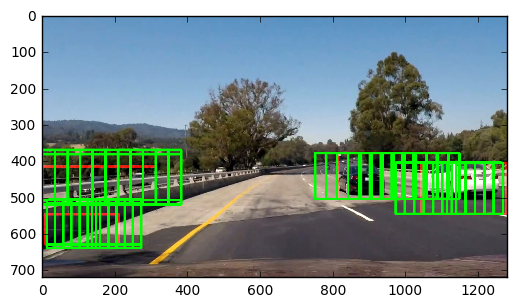

In [1223]:
plt.imshow(img_)

[[ 0.98378843]]


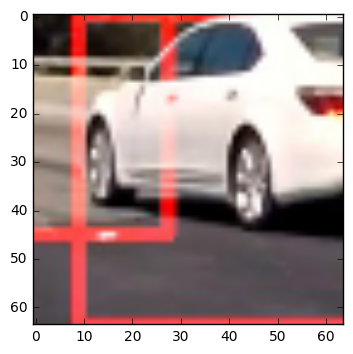

In [1234]:
cropout = np.array(windows[1][9]).flatten()
cropout = img[cropout[1]:cropout[3],cropout[0]:cropout[2]]
resized = cv2.resize(cropout, (64,64))
plt.imshow(resized)
print(classifier.predict(np.expand_dims(resized,0)))

In [1225]:
# create heatmap again
def create_heatmap(img, windows):
    
    windows = list(itertools.chain.from_iterable(windows))
    
    heatmap = np.zeros((img.shape[0],img.shape[1]))
    
    cropout_arr = np.zeros((len(windows),64,64,3))
    
    for i,v in enumerate(windows):    
        cropout = img[v[0][1]:v[1][1],v[0][0]:v[1][0],:]
        cropout_arr[i,]=cv2.resize(cropout, (64,64))
        

    cropout_pred = classifier.predict(cropout_arr) #(len, 1)
    #print(cropout_pred)
    threshold = 0.9
    
    thresholded = np.array(windows)[np.tile(cropout_pred>threshold,2)]
    car_windows = thresholded.reshape((int(thresholded.shape[0]/2),2,2))
    
    for x in list(car_windows):
        heatmap[x[0][1]:x[1][1],x[0][0]:x[1][0]] += 1
    
#     heatmap[heatmap < 2]=0
    
    return heatmap

In [1226]:
heatmap = create_heatmap(img, windows)

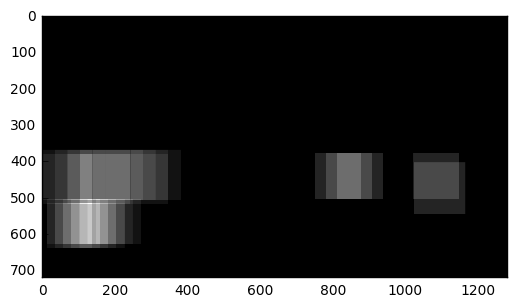

In [1227]:
plt.imshow(heatmap, cmap='gray')

In [1228]:
labels, n_cars = label(heatmap)
small_, bboxes = draw_labeled_bboxes(img, labels, n_cars)

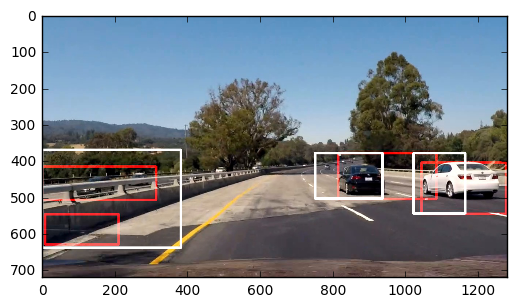

In [1229]:
plt.imshow(small_)

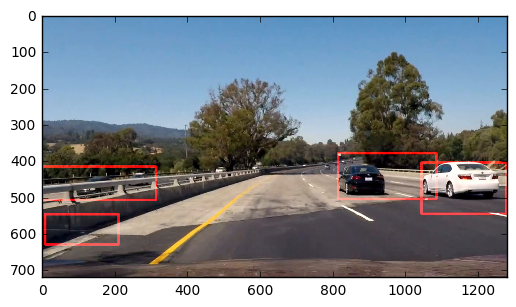

In [1167]:
plt.imshow(img)